# Calibration curve

## Introduction

The score you get from a binary classifier (that outputs a number between 0 and 1.0 is not necessarily a well-calibrated probability. Even some models that provide a method that return the probability prediction can give you poorc estimates of the class probabilities. For these cases, you have to calibrate the predicted probabilities.  The tools utilized to calibrate a model are sometimes called calibration curve (Python) and other, reliability diagrams (R).

Some machine learning algorithm already returned their predicted probabilities already calibrated.

* Logistic Regression
* XGB Gradient Boostings for the objective funtions bellow:
    * 'binary:logistic' for bianry classification
    * 'multi:softprob'  for multiclass classification
 
Other algorithms have to calibrate their predicted probabilities. Some examples include neural networks, support vector machines, and decision trees.


**A well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predicted probability value close to 0.8 (confident level), approximately 80% actually belong to the positive class.**


## Calibration curve


Bellow are the steps to make calibration curve:


1. the prediction space is discretized into bins

For instance, lets pretend that the test dataset has 4 sample and a binnary classfier $C$ was trained and reported this predicted probabilities for this data.

  
 $bin_1: (Pos, X_1, 0.2), (Neg, X_2, 0.4)$  
 $bin_2: (Pos, X_3, 0.6), (Pos, X_4, 0.8)$  
 
 PS: The first bin has 2 samples. One Positive (class=1) and another Negative (class=0). The respectived predicted probabilities reported by $C$ are: $0.2$ and $0.4$

2. For each bin, the mean predicted probability ($mop$) and the freqeuncy of positive ($fop$) cases are computed.

$bin_1:(fop: 0.5, mop: 0.3) $  
$bin_2:(fop: 1.0, mop: 0.7) $  

3. The  mean predicted probability is plotted against freqeuncy of positive cases

If the model is well calibrated the points will fall near the diagonal line. Below the diagonal: The model has **over-forecast**; the probabilities are too large. Above the diagonal: The model has **under-forecast**; the probabilities are too small.


## When to calibrate

Whether or not we want well calibrated probabilities depends entirely on the problem we are trying to solve.

On the cases where you only need to rank observations from most likely to least likely such as user identification or score similarity you do NOT have to calibrate the predicted probability.

For cases where you need to make decisions based on model outputs is recommended to do it:

* credit default probabilities, it may the company's policy to contact every customer whose default risk is over 0.6.
* If your model outputs risk of heart failure in the next 3 months, the doctors (or medical guidelines) may need to act on the people whose risk is above 0.5, to prevent the event from taking place
* Fraud detection, you might decide to take an action based ont the transcation values and the predicted probability


## Type of calibration

* Isotonic Calibration (also called Isotonic Regression) fits a piecewise function to the outputs of your original model instead

* Sigmoid Calibration simply means to fit a Logistic Regression classifier using the (0 or 1) outputs from your original model.

**The first one is the most used because tend to have better results.**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification

from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

## Calibration curve for complex data

The data has non informative and redundant features.

We are going to compare the predicted probability whithout calibration for differents models. One important thing, is that depend of the data, some classifiers can have already a good predicted probability, and it is not necessary to calibrate. Normally is the case of Logistic Regression, but suprisingly, many times Random Forest also exibited calibrated predicted probailities.


### Data

In [27]:
X, y = make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=3,random_state=2018)


### split train, test for calibration

In [28]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.9, random_state=42)

### Train the models

In [29]:
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=50,random_state=0)
gbo = GradientBoostingClassifier(n_estimators=50,random_state=0)

### Calibration curve for all models 

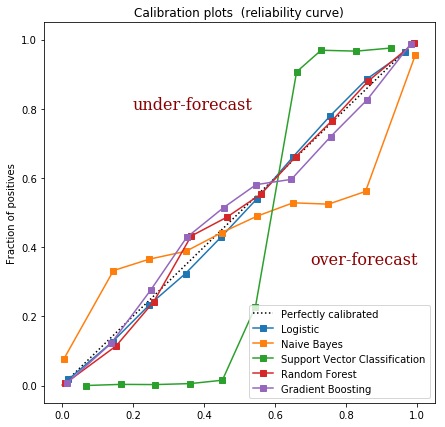

In [31]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(7, 7))

axes = plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1 =axes[0]
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (gbo, 'Gradient Boosting')
                 ]:
    
    clf.fit(X_train, y_train)
    
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
        
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    
    
plt.text(0.2, 0.8, r'under-forecast', fontdict=font)
plt.text(0.70, 0.35, r'over-forecast', fontdict=font)
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)');

### Calibrate with isotonic regression

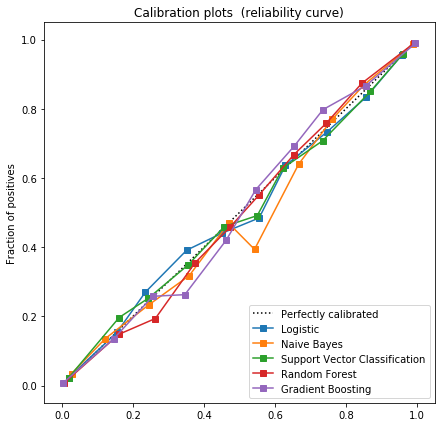

In [21]:
fig = plt.figure(figsize=(7, 7))

axes = plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1 =axes[0]
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (gbo, 'Gradient Boosting')
                 ]:
    
    clf.fit(X_train, y_train)
    
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
        
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
    
    clf_isotonic.fit(X_train, y_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
    
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)');


### Comparative between isotonic and sigmoid calibration (**WIP**)

https://scikit-learn.org/stable/modules/calibration.html#calibration  
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html  


In [24]:
n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])


In [25]:
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)


### Plot the data and the predicted probabilities

Text(0.5,1,'Data')

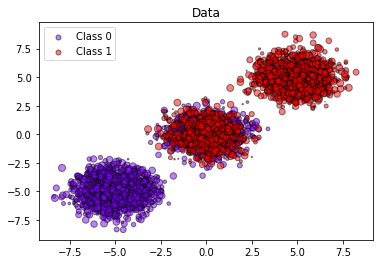

In [13]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color,
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
